# ARIMA Model (baseline model)

In [4]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import pmdarima as pm
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
%load_ext autoreload
%autoreload 2

## Import data

In [3]:
from electricity_price_predictor.data import get_price, get_shifted_price

In [4]:
df= get_shifted_price()
df.head()

price
time                      
2015-01-01 00:00:00  25.02
2015-01-01 01:00:00  18.29
2015-01-01 02:00:00  16.04
2015-01-01 03:00:00  14.60
2015-01-01 04:00:00  14.95

## Decomposition of hourly data

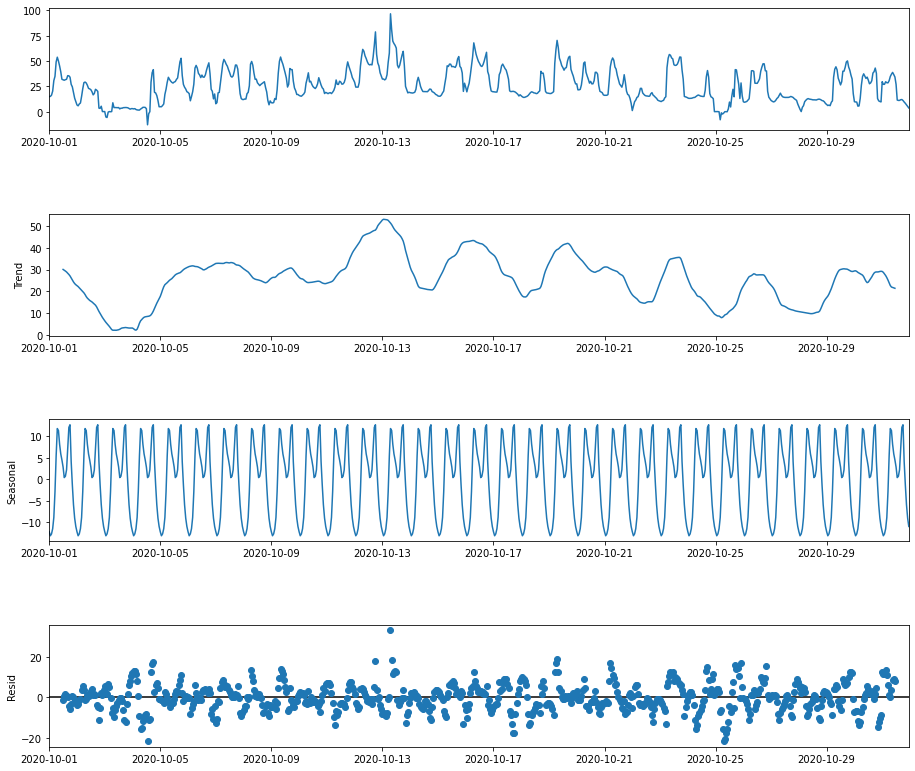

In [5]:
df_2020_10 = df[(df.index.year==2020) & (df.index.month==10)]
decompose_2020_10 = seasonal_decompose(df_2020_10, model='additive')
fig = decompose_2020_10.plot()
fig.set_size_inches(14, 12);

## Decomposition of df_hour_11

In [5]:
# get all the data for 11 am 
df_hour_11 = df[df.index.hour==11]
df_hour_11.head()

price
time                      
2015-01-01 11:00:00  16.08
2015-01-02 11:00:00  15.08
2015-01-03 11:00:00  22.31
2015-01-04 11:00:00  27.32
2015-01-05 11:00:00  40.97

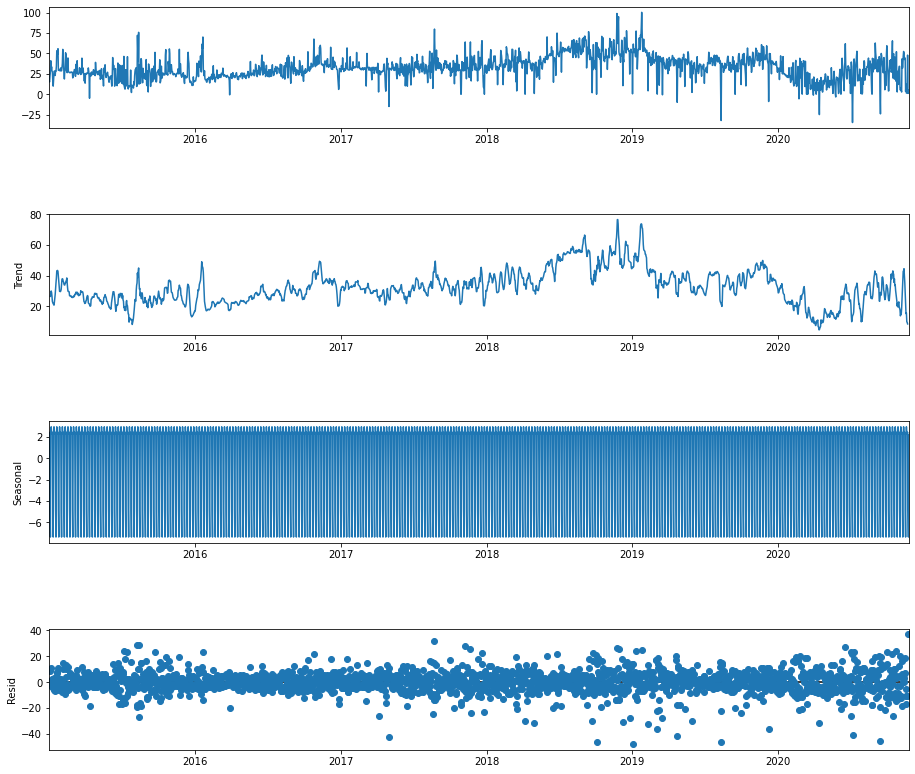

In [6]:
# for 5 years
decompose_5y = seasonal_decompose(df_hour_11, model='additive')
fig = decompose_5y.plot()
fig.set_size_inches(14, 12);

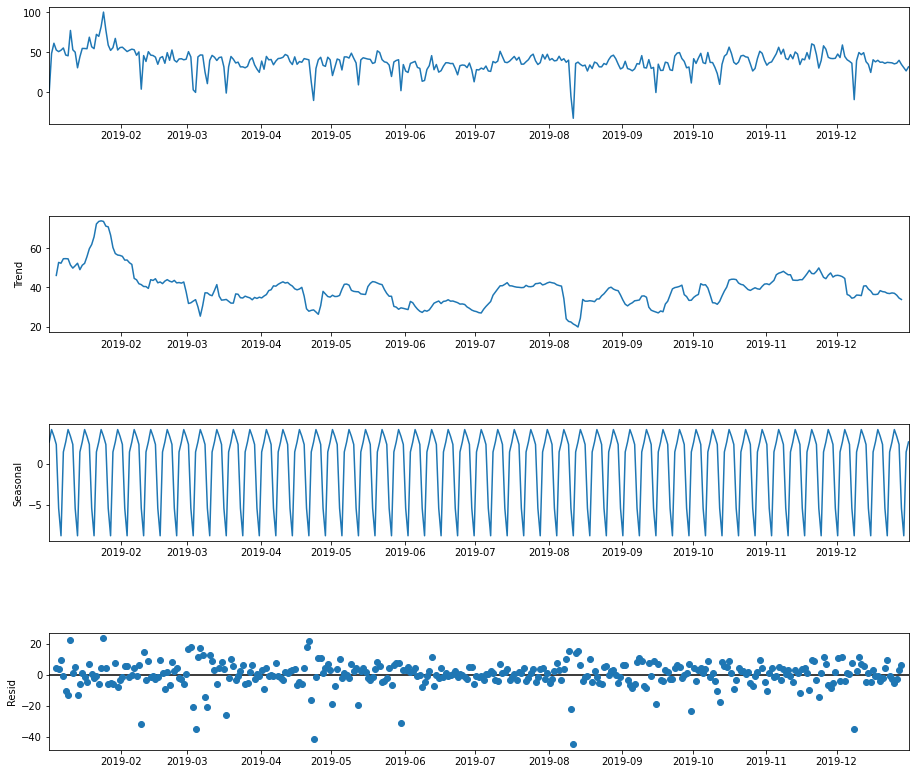

In [8]:
# for year 2019 
decompose_2019 = seasonal_decompose(df_hour_11[(df_hour_11.index.year==2019)], model='additive')
fig = decompose_2019.plot()
fig.set_size_inches(14, 12);

- No clear monthly or yearly seasonality is observed.
- There is a clear weekly seasonality, which is likely caused by electricity usage in household

## Explore the stationarity

In [8]:
# remove the weekly seasonality
df_hour_11_deseasonalized = pd.DataFrame((df_hour_11.price - decompose_5y.seasonal), columns=['price'])

Text(0.5, 1.0, 'First order diff of deseasonalized series')

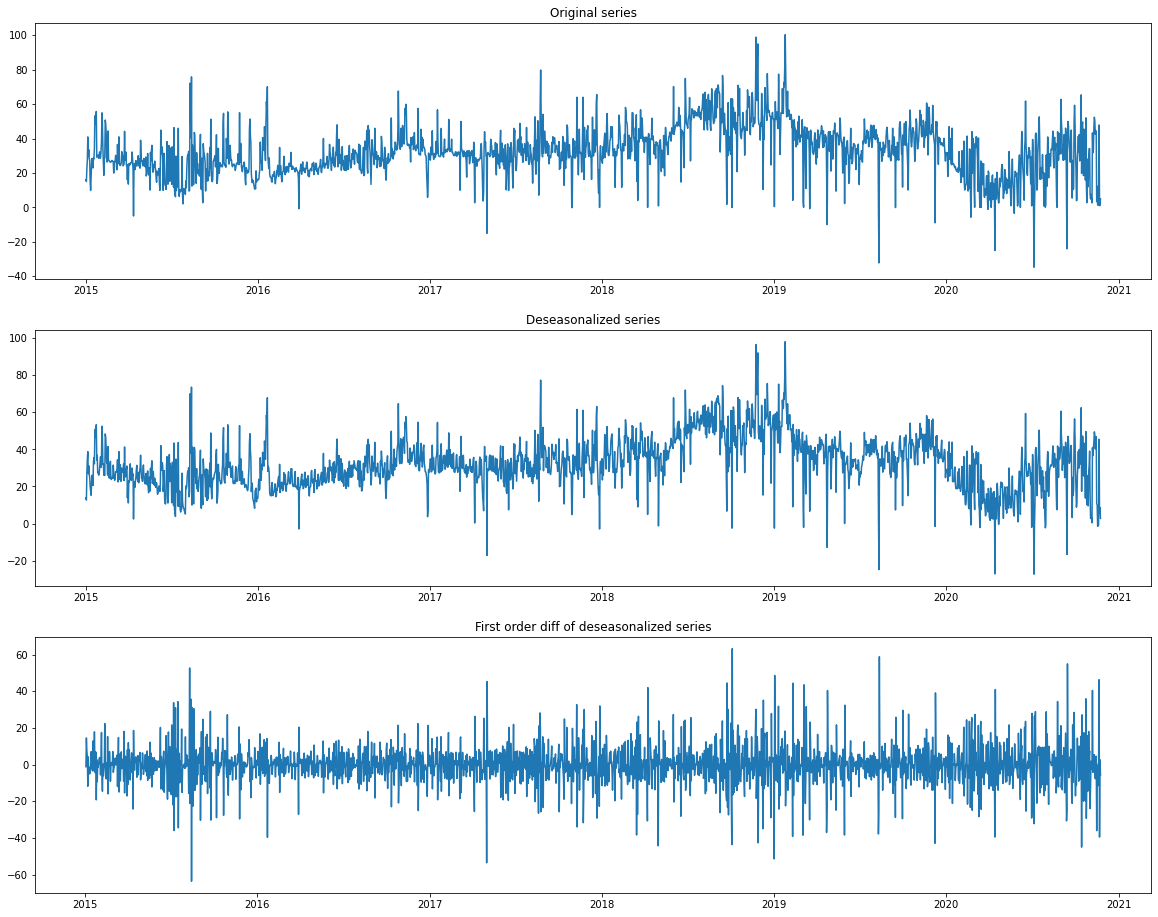

In [10]:
# Explore stationarity of deseasonalized data

fig, axs = plt.subplots(3, 1, figsize=(20,16))
# Original series
axs[0].plot(df_hour_11)
axs[0].set_title('Original series')

# Deseasonalized Series
axs[1].plot(df_hour_11_deseasonalized) 
axs[1].set_title('Deseasonalized series')

# Week + Normal differencing
axs[2].plot(df_hour_11_deseasonalized.diff(1))
axs[2].set_title('First order diff of deseasonalized series')

In [11]:
# ADF test
print('ADF of deseasonalized data: ', adfuller(df_hour_11_deseasonalized)[1])
print('ADF of first order diff deseasonalized data: ', adfuller(df_hour_11_deseasonalized.diff(1).dropna())[1])

ADF of deseasonalized data:  0.011862953608666961
ADF of first order diff deseasonalized data:  9.452731282679423e-28


## Autocorrelation

### Original series

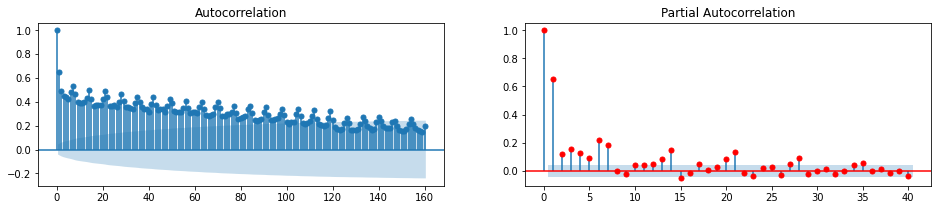

In [12]:
# plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11, lags=160, ax=axes[0]);
plot_pacf(df_hour_11, lags=40, ax=axes[1], color='r');

- ACF shows weekly seasonality and one timepoint is correlated with pass 120 timepoints even more
- PACF also shows weekly seasonality

### After removing weekly seasonality

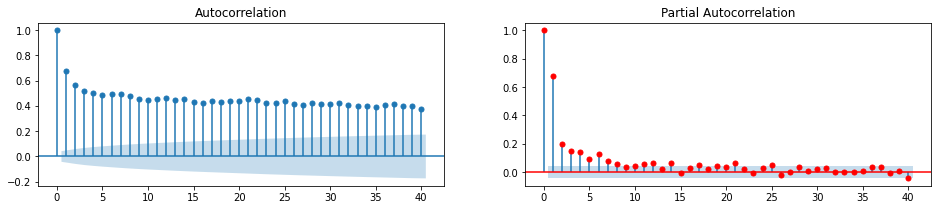

In [13]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized, lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized, lags=40, ax=axes[1], color='r');

- Both ACF show slow gradual decrease, should consider first order diff 

### After removing weekly seasonality and perform first order diff

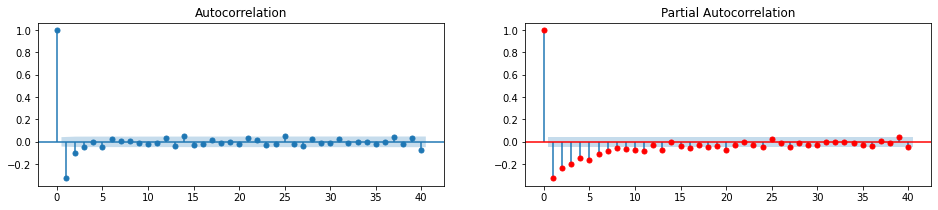

In [14]:
# ACF and PACF after removing weekly seasonality
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[0]);
plot_pacf(df_hour_11_deseasonalized.diff(1).dropna(), lags=40, ax=axes[1], color='r');

- According to ACF and PACF, (p, d, q) = (1-7, 1, 1-2) 

## ARIMA model based on ACF and PACF

In [15]:
# grid search the hyper params
smodel = pm.auto_arima(df_hour_11_deseasonalized, seasonal=False, 
                       start_p=0, max_p=2, 
                       d=1,
                       start_q=0, max_q=2, 
                       trace=True) 

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16475.953, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16234.258, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15973.860, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16473.953, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15803.768, Time=0.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=15804.834, Time=1.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15804.785, Time=1.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15833.976, Time=0.56 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16116.062, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15805.243, Time=2.51 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=15801.789, Time=0.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=15971.868, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16232.259, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=15802.856, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0

In [9]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(df_hour_11_deseasonalized, order=(1,1,1), freq='D')
arima = arima.fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                 2153
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7897.884
Method:                       css-mle   S.D. of innovations              9.479
Date:                Sun, 29 Nov 2020   AIC                          15803.768
Time:                        01:27:15   BIC                          15826.466
Sample:                    01-02-2015   HQIC                         15812.071
                         - 11-23-2020                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0031      0.022     -0.145      0.885      -0.045       0.039
ar.L1.D.price     0.3672      0.024     15.173      0.000       0.320       0.415
ma.L1.D.price    -0.9335      0.010    -89.974      0.000      -0.954      -0.913
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.7232           +0.0000j            2.7232            0.0000
MA.1            1.0712           +0.0000j            1.0712            0.0000
-----------------------------------------------------------------------------
"""

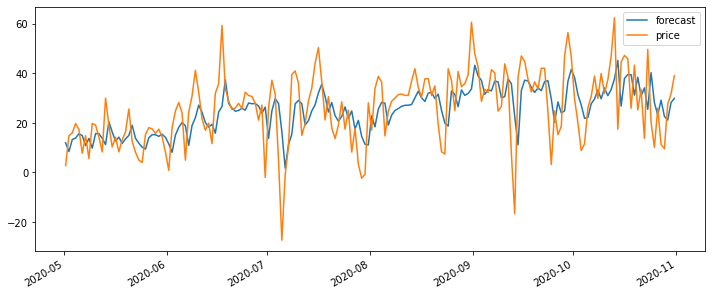

In [17]:
arima.plot_predict('2020-05', '2020-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

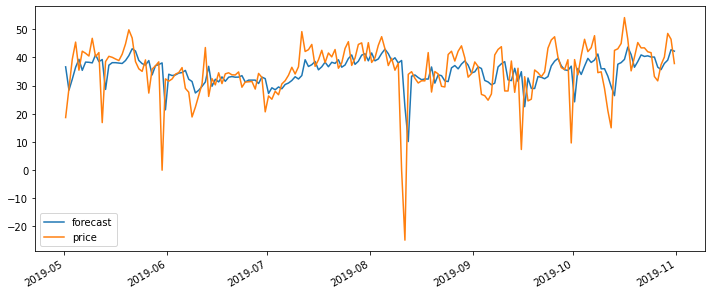

In [18]:
arima.plot_predict('2019-05', '2019-10')
fig = plt.gcf() 
fig.set_size_inches(12, 5);

## Evaluate the model

In [10]:
# Create a correct Training/Test split to predict the last 50 points
train = df_hour_11[df_hour_11.index <= '2019-10-22 11:00:00']
test = df_hour_11[(df_hour_11.index > '2019-10-22 11:00:00') & \
                  (df_hour_11.index < '2019-11-20 11:00:00')]

In [11]:
# Decomposition
decompose = seasonal_decompose(train, model='additive')
train_decompose = pd.DataFrame((train.price - decompose.seasonal), columns=['price'])

In [12]:
# Train the Model
arima = ARIMA(train_decompose, order=(1, 1, 1), freq='D')
arima = arima.fit()
# Forecast
forecast, std_err, confidence_int = arima.forecast(len(test), alpha=0.05)  # 95% confidence

In [22]:
# define a function for re-compose forecast and confident-intervals

def re_compose(forecast):
    '''take forecast price and confidence_intervals as input, returns re-composed forecast price and confident_int'''
    forecast = pd.DataFrame(forecast, index=test.index, columns=['price'])
    forecast['dayofweek'] = forecast.index.dayofweek
    # get the base price of day of week
    week_price = decompose.seasonal.to_frame().set_index(decompose.seasonal.index.dayofweek).drop_duplicates()
    # add the base price to the forecast price
    for i in range(7):
        value = week_price.loc[i, 'seasonal']
        forecast[forecast.dayofweek == i] = forecast[forecast.dayofweek == i] +value
        forecast['dayofweek'] = forecast.index.dayofweek
    forecast.drop(columns=['dayofweek'], inplace=True)
    return forecast    

In [20]:
# define a function for plotting the forecast

def plot_forecast(forecast, train, test, lower_int, upper_int, mape=None, mase=None):
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(forecast, label='forecast', color='orange')
    plt.fill_between(forecast.index, lower_int, upper_int, color='k', alpha=.15)
    title = 'Forecast vs Actuals'
    if isinstance(mape, str):
        title +=f' MAPE:{mape}'
    if isinstance(mase, str):
        title +=f' MASE:{mase}'
    plt.title(title)
    plt.legend(loc='upper left', fontsize=8);

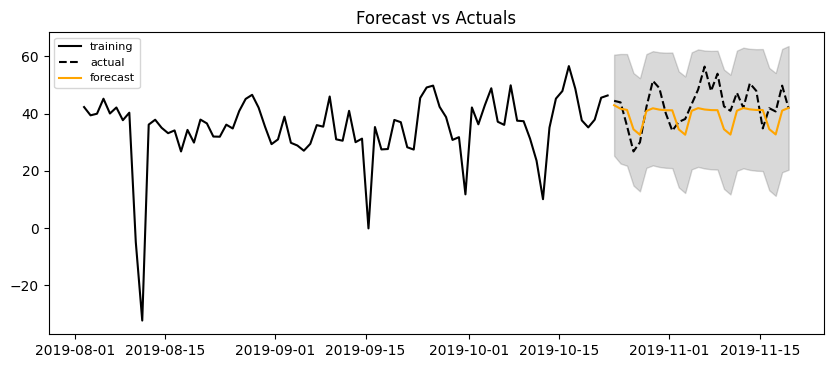

In [24]:
# plot the forecast
forecast = re_compose(forecast)
upper_int = re_compose(confidence_int[:, 1]).price
lower_int = re_compose(confidence_int[:, 0]).price
plot_forecast(forecast, train[train.index > '2019-08-1 11:00:00'], test, lower_int, upper_int)

In [13]:
# define a function for MAPE
def get_mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mape = np.round(mape,2)
    return f'{mape}%' 

In [14]:
get_mape(test, forecast) # this was near 50% for2020

'14.91%'

In [39]:
# define a function for MASE
def get_mase(y_true, y_pred, train_y):
    y_true, y_pred, train_y = np.array(y_true), np.array(y_pred), np.array(train_y)
    upper = np.mean(np.abs(y_pred-y_true))
    train_t = train_y[:-1]
    train_t_1 = train_y[1:]
    lower = np.mean(np.abs(train_t-train_t_1))
    return upper/lower

In [40]:
get_mase(test, forecast, train.price)

0.8838385790759249

## Check residuals for inference validity

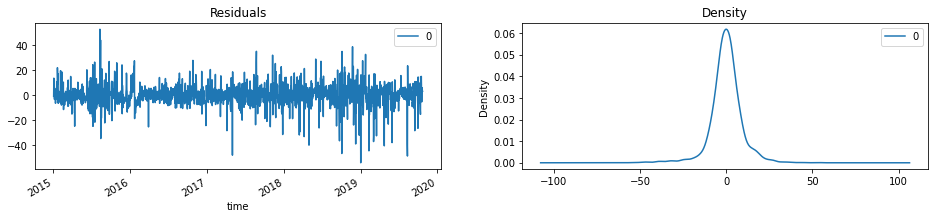

In [27]:
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

## SARIMA Model

In [28]:
# Grid search hyper params
smodel = pm.auto_arima(train, seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13516.708, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13323.649, Time=0.80 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13092.703, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13514.712, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13103.004, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.34 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13075.461, Time=2.72 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.24 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13483.049, Time=1.37 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12907.006, Time=3.95 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12923.557, Time=1.94 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12800.216, Time=11.37 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=12798.448, Time=5.68 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=12918.156, Time=1.78 sec
 ARIMA(1,1,1)(2,0,1)[7] inter

In [ ]:
# Build Model
sarima = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1,0,1,7), freq='D')
sarima = sarima.fit()

# Forecast
results = sarima.get_forecast(len(test), alpha=0.05)
forecast = sarima.forecast(len(test), alpha=0.05)
confidence_int = results.conf_int()

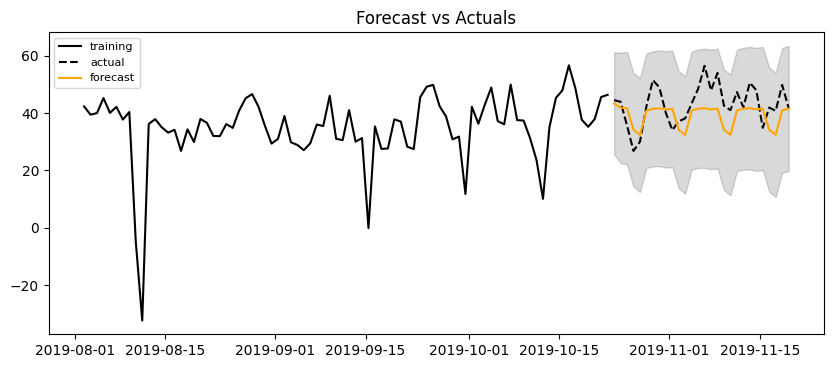

In [30]:
# plot the forecast
plot_forecast(forecast, 
              train[train.index > '2019-08-1 11:00:00'], 
              test, 
              confidence_int['lower price'],
              confidence_int['upper price'])

In [31]:
get_mape(test, forecast)

'16.11%'

## Walk forward validation of SARIMA

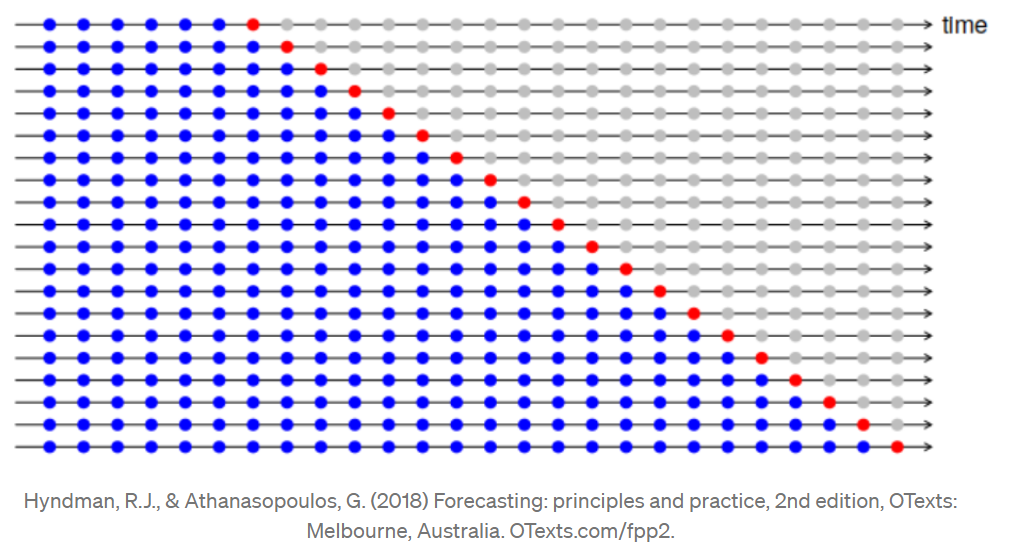

In [5]:
def train_sarima(df=df_hour_11, split_date = '2019-10-22 11:00:00', n=30):
    '''take a date and a number(n) and forecast for next n days and returns 
    forecast, upper_intervals, lower_intervals, mape, test'''
    
    # formating split_date
    split_date = pd.DatetimeIndex(np.array([split_date]))
    
    # get train and test for plotting only
    train = df[(df.index <= split_date[0])]
    test = df[(df.index > split_date[0]) & \
                      (df.index <= (split_date + pd.Timedelta(days=n))[0])]
    
    # will collect following information from forecast
    forecasts = []
    upper = []
    lower = []
    
    # loop over to get walk forward forecast for n days
    for i in range(1, n+1):
        
        # walk one day forward to set train_set
        new_date = df[df.index == split_date[0]].index + pd.Timedelta(days=i)
        train_set = df[df.index < new_date[0]]
        
        # Build Model
        sarima = SARIMAX(train_set, order=(1, 1, 1), seasonal_order=(1,0,1,7), freq='D')
        sarima = sarima.fit()

        # Forecast
        results = sarima.get_forecast(1, alpha=0.05)
        forecast = sarima.forecast(1, alpha=0.05)
        confidence_int = results.conf_int()

        # add forecast result into the list
        lower.append(confidence_int['lower price'][0])
        upper.append(confidence_int['upper price'][0])
        forecasts.append(forecast[0])
    
    # calculate the mape
    mape = get_mape(test.price, forecasts)
    mase = get_mase(test.price, forecasts, train.price)
    
    # create forecast df with datetimeIndex
    forecast = pd.DataFrame(forecasts, index=test.index, columns=['price'])

    return forecast, lower, upper, mape, mase, train, test

In [18]:
from electricity_price_predictor.sarima import train_sarima
from electricity_price_predictor.sarima import plot_forecast

In [ ]:
# evaluate the sarima model for test_set(2019-6-30 till 2019-12-31)
forecast, lower, upper, mape, mase, train, test = train_sarima(hour=11, split_date = '2019-6-30 11:00:00', n=184)

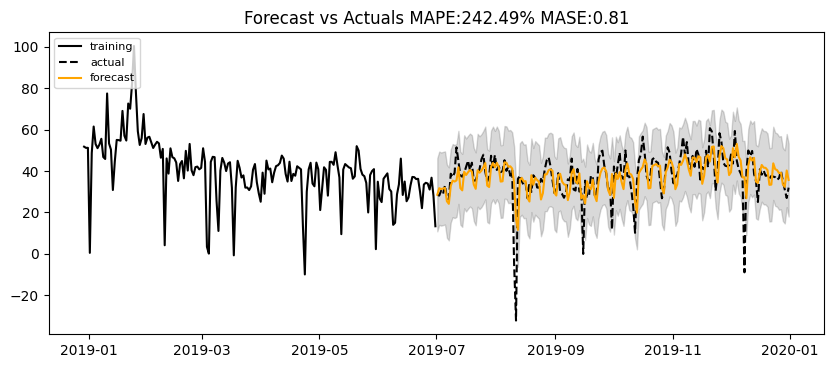

In [20]:
plot_forecast(forecast, train.iloc[-184:], test, lower, upper, mape=mape, mase=mase)

In [24]:
# save the results in csv
forecast['lower_int']=lower
forecast['upper_int']=upper
forecast['mape']=mape
forecast['mase']=mase
forecast.to_csv("sarima_forecast_2019_6_12.csv")

In [ ]:
forecast, lower, upper, mape, mase, train, test = train_sarima(hour=11, split_date = '2019-10-22 11:00:00', n=30)

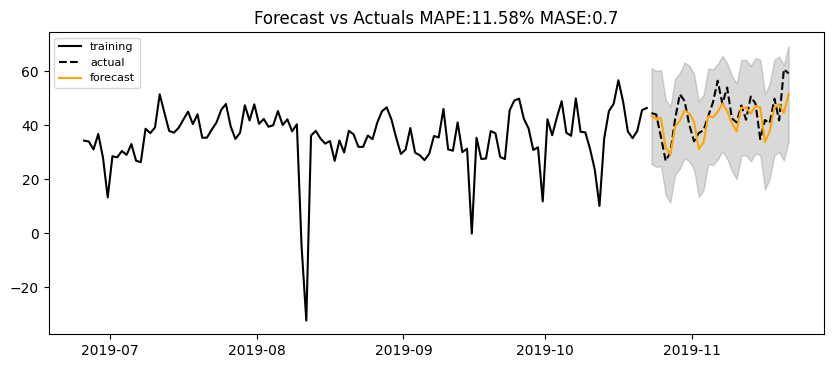

In [21]:
plot_forecast(forecast, train.iloc[-120:], test, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = train_sarima(hour=11, split_date = '2019-11-22 11:00:00', n=30)

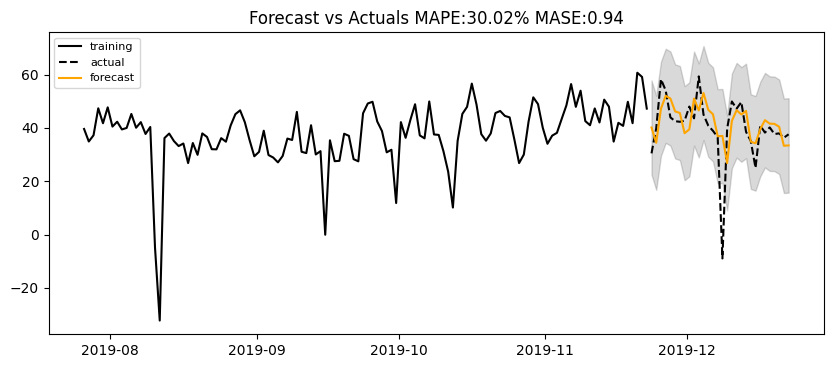

In [23]:
plot_forecast(forecast, train.iloc[-120:], test, lower, upper, mape=mape, mase=mase)

- As shown in the plot, our SARIMA model can capture most of the patterns but it failed to capture the sudden drops.
- To capture the sudden drops, exogenous features need to be included.
- Now, what could cause negative electricity price??

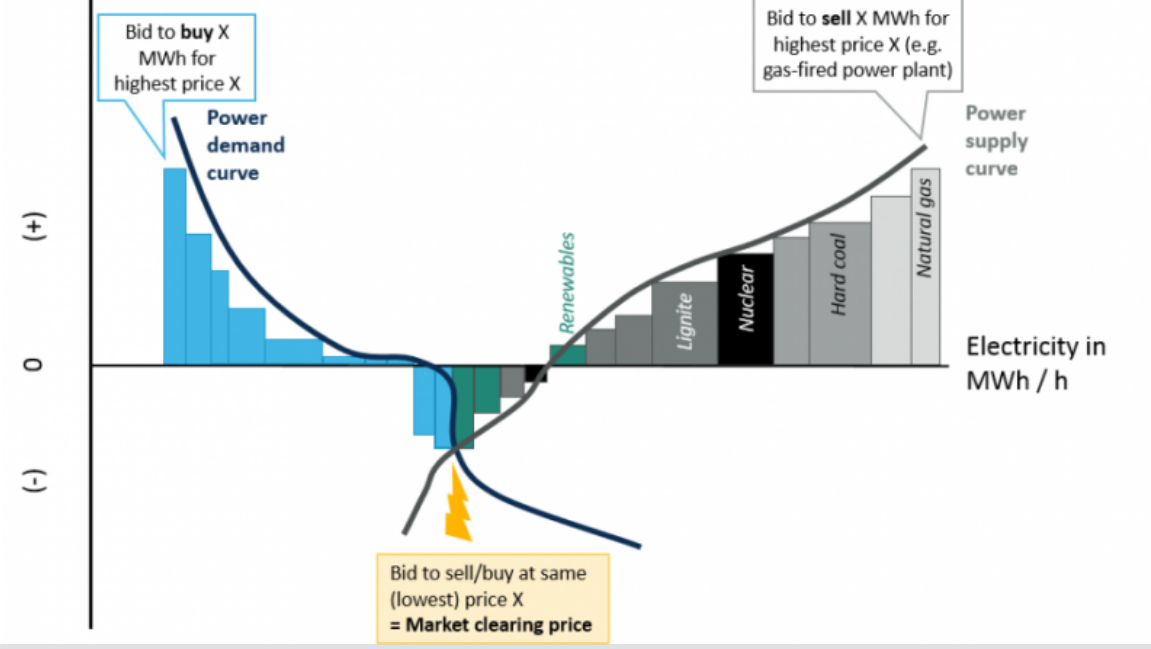

After doing some research, I found that strong wind generation often cause negative power price in DK.

# SARIMAX Model

In [1]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
%load_ext autoreload
%autoreload 2

## Import data

In [10]:
from electricity_price_predictor.data import get_all

In [115]:
df = get_all()
df.head()

price    load  coal_price      temp  feels_like  \
2015-01-01 11:00:00  16.08  2194.0         NaN  6.732469   -0.346708   
2015-01-02 11:00:00  15.08  2673.0         NaN  6.849566   -2.364317   
2015-01-03 11:00:00  22.31  2405.0         NaN  4.332541   -1.562728   
2015-01-04 11:00:00  27.32  2383.0         NaN  3.296271   -2.594814   
2015-01-05 11:00:00  40.97  3099.0         NaN  4.498201    1.665528   

                      humidity  clouds_all  wind_speed   total_prod  \
2015-01-01 11:00:00  93.413145   91.036933    8.724397  3909.281833   
2015-01-02 11:00:00  80.994869   52.392560   11.233930  4247.975683   
2015-01-03 11:00:00  88.760764   38.333790    6.187115  3391.054053   
2015-01-04 11:00:00  79.233305   11.509847    5.591671  3606.491107   
2015-01-05 11:00:00  93.718424   88.775936    2.044551  2175.075494   

                       wind_prod  wind_share  holiday  weekend  
2015-01-01 11:00:00  3183.801317    0.814421      1.0      0.0  
2015-01-02 11:00:00  3405.313993    0.801632      0.0      0.0  
2015-01-03 11:00:00  2380.964290    0.702131      0.0      1.0  
2015-01-04 11:00:00  2268.581247    0.629027      0.0      1.0  
2015-01-05 11:00:00   234.576723    0.107848      0.0      0.0

## Explore exogenous features

### Compare the trend of price to trends of exog features

Text(0, 0.5, 'coal_price')

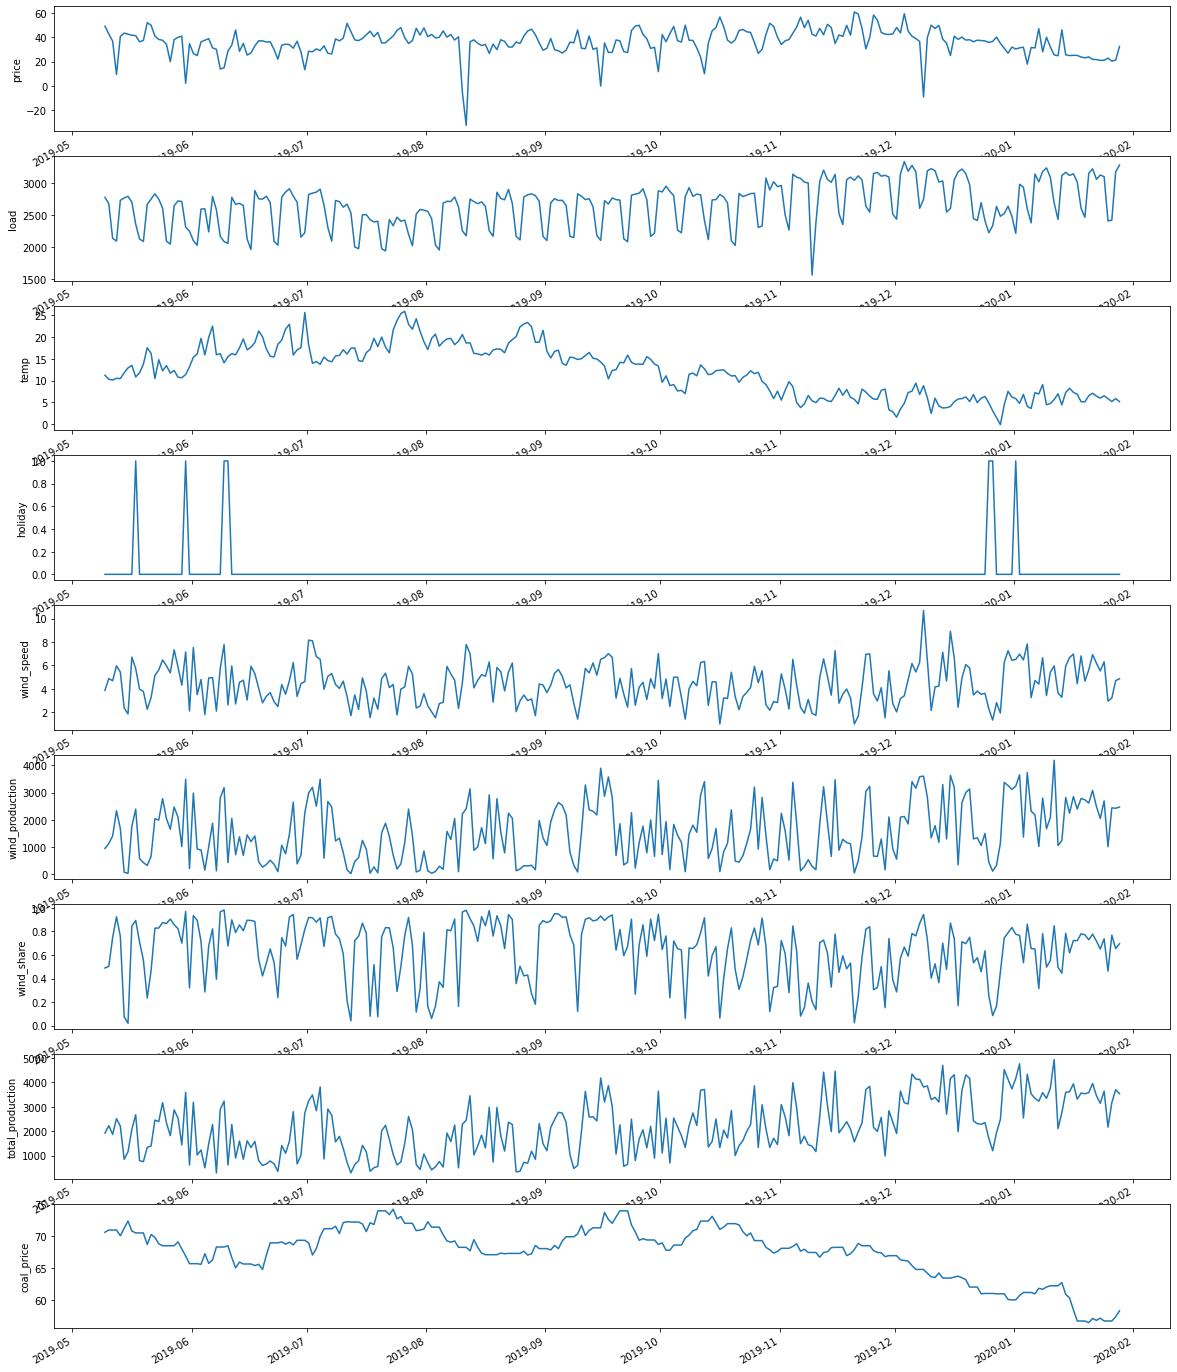

In [39]:
fig, ax = plt.subplots(9,1, figsize=(20,27))
df.price[-560:-295].plot(ax=ax[0])
ax[0].set_ylabel('price')
df.load[-560:-295].plot(ax=ax[1])
ax[1].set_ylabel('load')
df.temp[-560:-295].plot(ax=ax[2])
ax[2].set_ylabel('temp')
df.holiday[-560:-295].plot(ax=ax[3])
ax[3].set_ylabel('holiday')
df.wind_speed[-560:-295].plot(ax=ax[4])
ax[4].set_ylabel('wind_speed')
df.wind_prod[-560:-295].plot(ax=ax[5])
ax[5].set_ylabel('wind_production')
df.wind_share[-560:-295].plot(ax=ax[6])
ax[6].set_ylabel('wind_share')
df.total_prod[-560:-295].plot(ax=ax[7])
ax[7].set_ylabel('total_production')
df.coal_price[-560:-295].plot(ax=ax[8])
ax[8].set_ylabel('coal_price')

- total production highly depends on wind production and wind production highly depends on **wind_speed**
- **holidays** seems to have impact on price
- need further decomposition for temp and load

### Decompose and Compare 

In [41]:
# decompose price and load
tmp = df.dropna()
decompose_price = seasonal_decompose(tmp['price'], model='additive')
decompose_load = seasonal_decompose(tmp['load'], model='additive')
decompose_temp = seasonal_decompose(tmp['temp'], model='additive')
decompose_wind_speed = seasonal_decompose(tmp['wind_speed'], model='additive')
decompose_wind_production = seasonal_decompose(tmp['wind_prod'], model='additive')
decompose_production = seasonal_decompose(tmp['total_prod'], model='additive')
decompose_holiday = seasonal_decompose(tmp['holiday'], model='additive')
decompose_coal = seasonal_decompose(tmp['coal_price'], model='additive')

**Trends in 5 years**

Text(0, 0.5, 'coal_price')

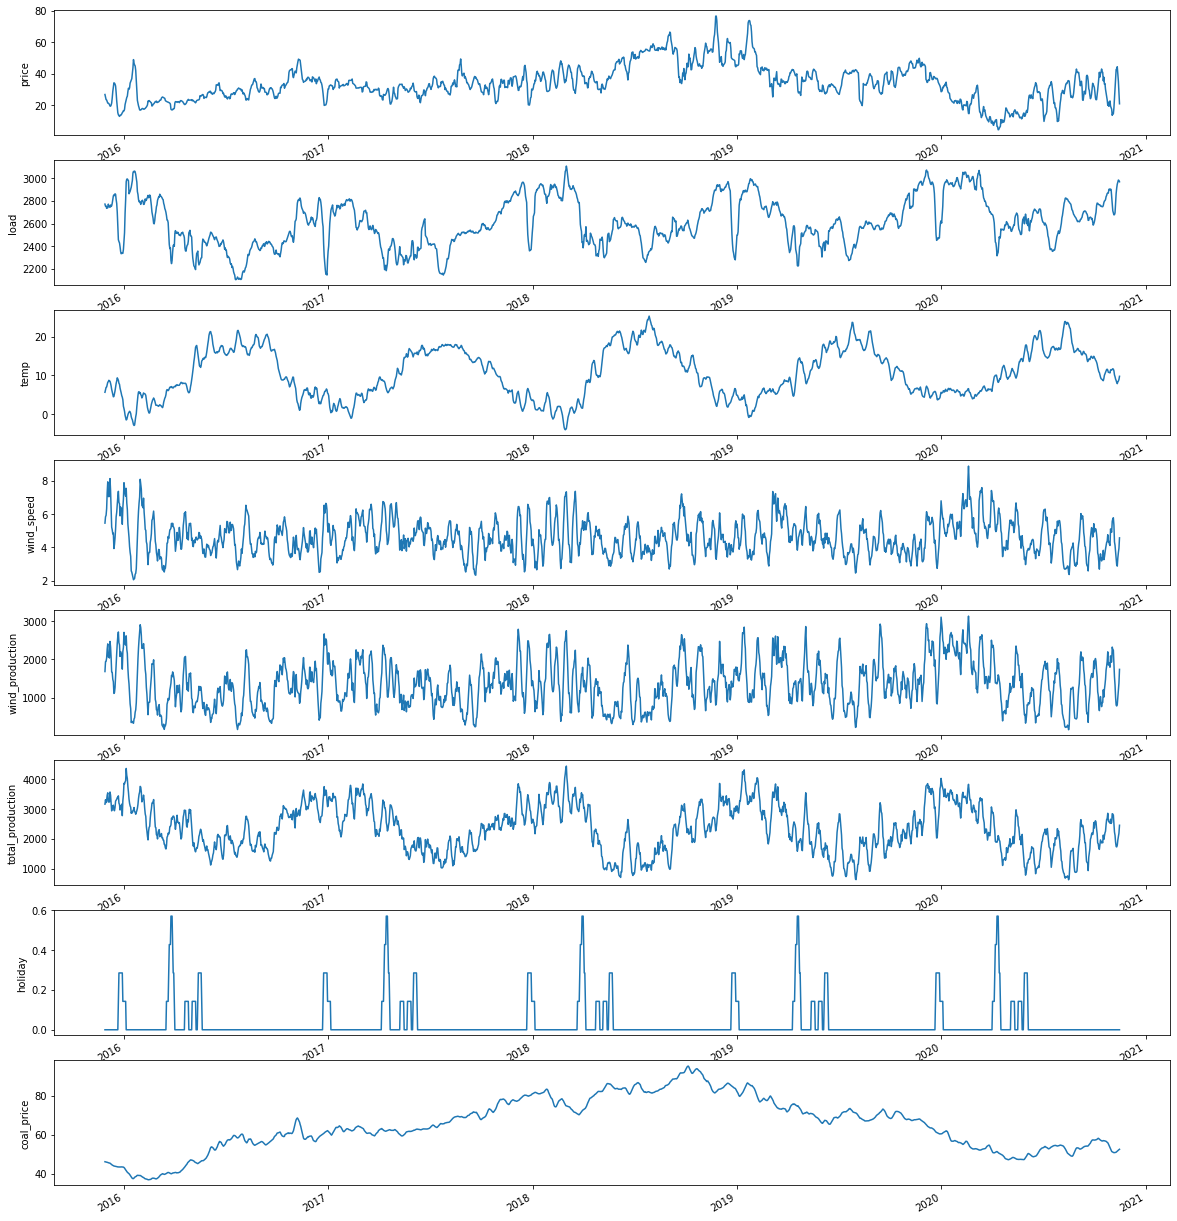

In [42]:
# compre the trends of all the above features
fig, ax = plt.subplots(8,1, figsize=(20,24))
decompose_price.trend.plot(ax=ax[0])
ax[0].set_ylabel('price')
decompose_load.trend.plot(ax=ax[1])
ax[1].set_ylabel('load')
decompose_temp.trend.plot(ax=ax[2])
ax[2].set_ylabel('temp')
decompose_wind_speed.trend.plot(ax=ax[3])
ax[3].set_ylabel('wind_speed')
decompose_wind_production.trend.plot(ax=ax[4])
ax[4].set_ylabel('wind_production')
decompose_production.trend.plot(ax=ax[5])
ax[5].set_ylabel('total_production')
decompose_holiday.trend.plot(ax=ax[6])
ax[6].set_ylabel('holiday')
decompose_coal.trend.plot(ax=ax[7])
ax[7].set_ylabel('coal_price')

- Load, temp and total production have clear seasonal seasonality

**Trends in 2019**

Text(0, 0.5, 'coal_price')

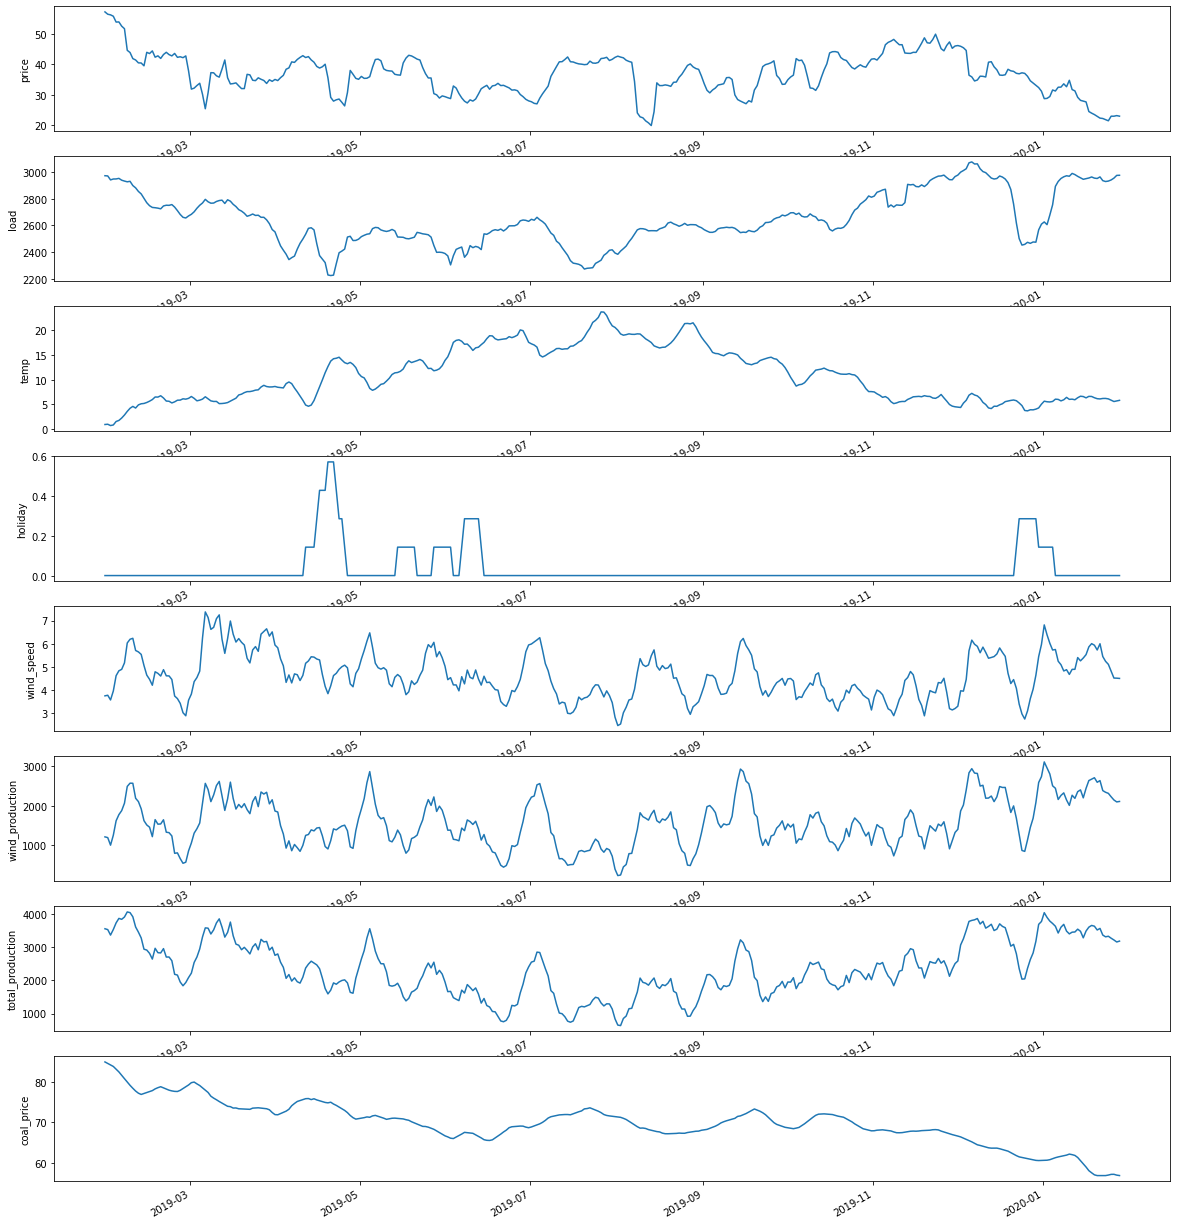

In [43]:
# compare the trends of all the above features 2019
fig, ax = plt.subplots(8,1, figsize=(20,24))
decompose_price.trend[-660:-295].plot(ax=ax[0])
ax[0].set_ylabel('price')
decompose_load.trend[-660:-295].plot(ax=ax[1])
ax[1].set_ylabel('load')
decompose_temp.trend[-660:-295].plot(ax=ax[2])
ax[2].set_ylabel('temp')
decompose_holiday.trend[-660:-295].plot(ax=ax[3])
ax[3].set_ylabel('holiday')
decompose_wind_speed.trend[-660:-295].plot(ax=ax[4])
ax[4].set_ylabel('wind_speed')
decompose_wind_production.trend[-660:-295].plot(ax=ax[5])
ax[5].set_ylabel('wind_production')
decompose_production.trend[-660:-295].plot(ax=ax[6])
ax[6].set_ylabel('total_production')
decompose_coal.trend[-660:-295].plot(ax=ax[7])
ax[7].set_ylabel('coal_price')

- part of price trend can be captured by load 

**Residuals in 2019**

Text(0, 0.5, 'coal_price')

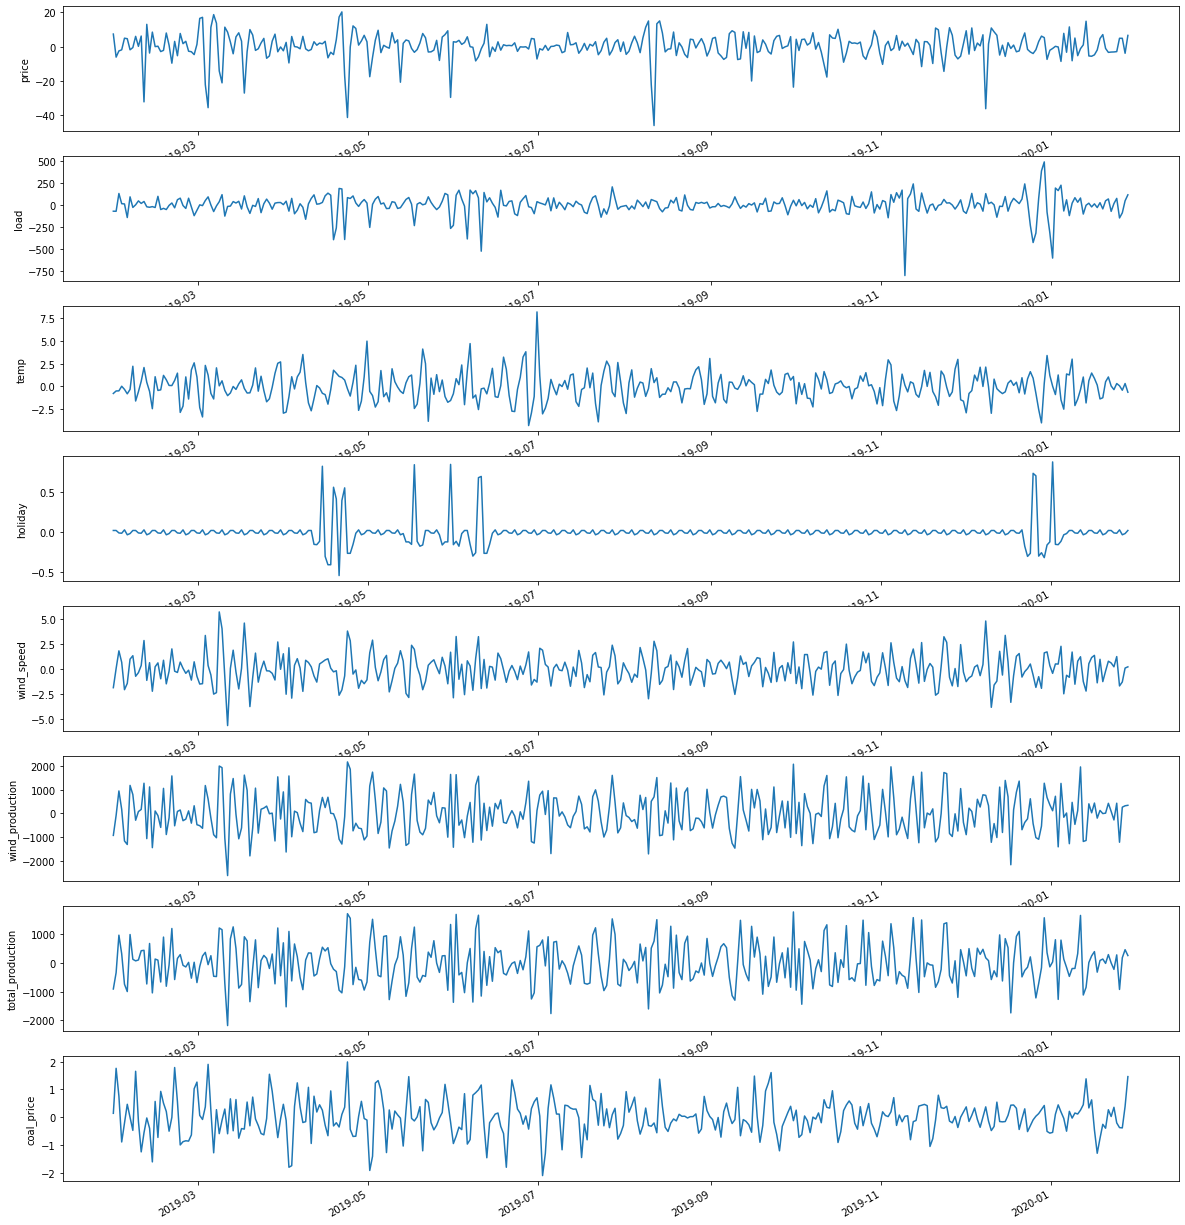

In [44]:
# compre the residuals of all the above features
fig, ax = plt.subplots(8,1, figsize=(20,24))
decompose_price.resid[-660:-295].plot(ax=ax[0])
ax[0].set_ylabel('price')
decompose_load.resid[-660:-295].plot(ax=ax[1])
ax[1].set_ylabel('load')
decompose_temp.resid[-660:-295].plot(ax=ax[2])
ax[2].set_ylabel('temp')
decompose_holiday.resid[-660:-295].plot(ax=ax[3])
ax[3].set_ylabel('holiday')
decompose_wind_speed.resid[-660:-295].plot(ax=ax[4])
ax[4].set_ylabel('wind_speed')
decompose_wind_production.resid[-660:-295].plot(ax=ax[5])
ax[5].set_ylabel('wind_production')
decompose_production.resid[-660:-295].plot(ax=ax[6])
ax[6].set_ylabel('total_production')
decompose_coal.resid[-660:-295].plot(ax=ax[7])
ax[7].set_ylabel('coal_price')

## Select exogenous features

- I will compare the MAPE and MASE of a model **with one exog feature** to those of a model **without exog feature**.
- MAPE and MASE of walk forward validation for periods:(2019-10-22+30days), (2019-11-22+30days), (2019-12-22+30days)

In [17]:
from electricity_price_predictor.sarima import train_sarima, plot_forecast

In [54]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.69 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.69 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.46 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.36 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.78 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.99 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.94 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.99 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.42 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

### Without exogenous feature

In [ ]:
# ARIMA(1,1,1)(1,0,2)[7] intercept
forecast, lower, upper, mape, mase, train, test = \
train_sarima()

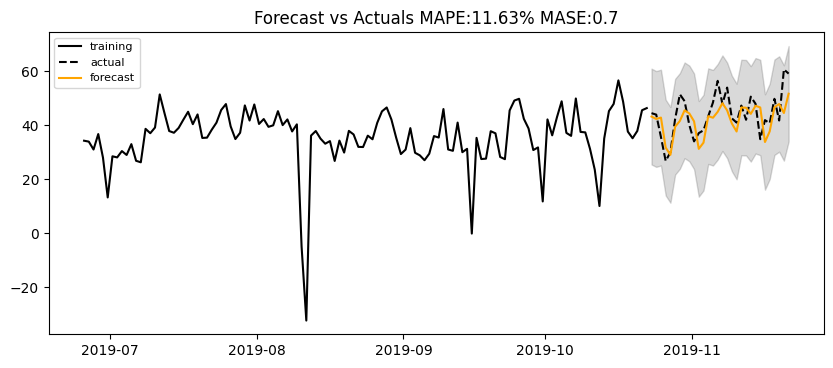

In [57]:
# 2019-10-22 + 30 days ARIMA(1,1,1)(1,0,2)[7] intercept
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [108]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(split_date = '2019-11-22 11:00:00')

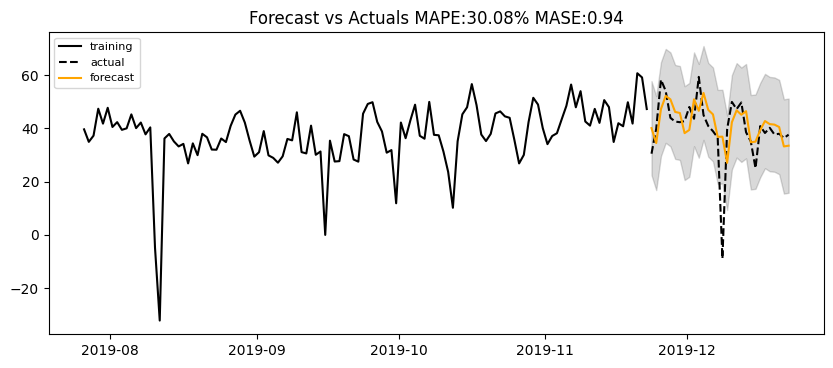

In [109]:
# 2019-11-22 + 30 days ARIMA(1,1,1)(1,0,2)[7] intercept
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(split_date = '2019-12-22 11:00:00')

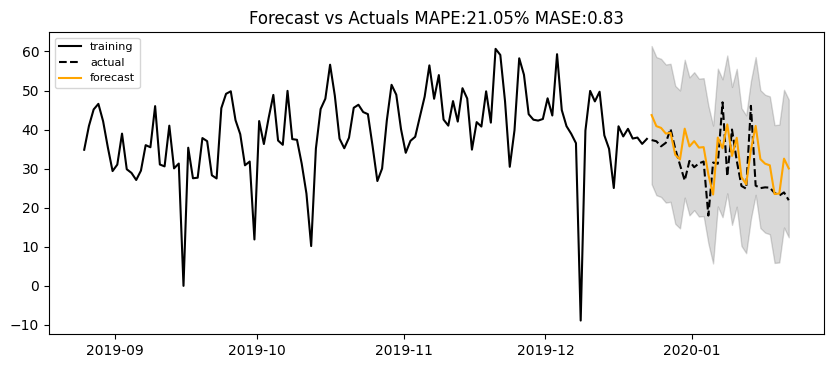

In [109]:
# 2019-12-22 + 30 days ARIMA(1,1,1)(1,0,2)[7] intercept
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

### Load as exogenous feature

In [56]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.load,
                       seasonal=True, m=7, 
                       start_p=0, max_p=1, start_q=0, max_q=1,
                       start_P=0, max_P=1, start_Q=0, max_Q=1, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.69 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=13083.198, Time=0.69 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=13492.764, Time=0.33 sec
 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=12911.556, Time=1.77 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=12937.388, Time=0.68 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.90 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.88 sec
 ARIMA(1,1,1)(1,0,0)[7]             : AIC=12909.652, Time=0.54 sec
 ARIMA(1,1,1)(0,0,0)[7]             : AIC=12935.474, Time=0.21 sec
 ARIMA(1,1,1)(1,0,1)[7]        

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=('load', (1,1,1), (1,0,0,7)))

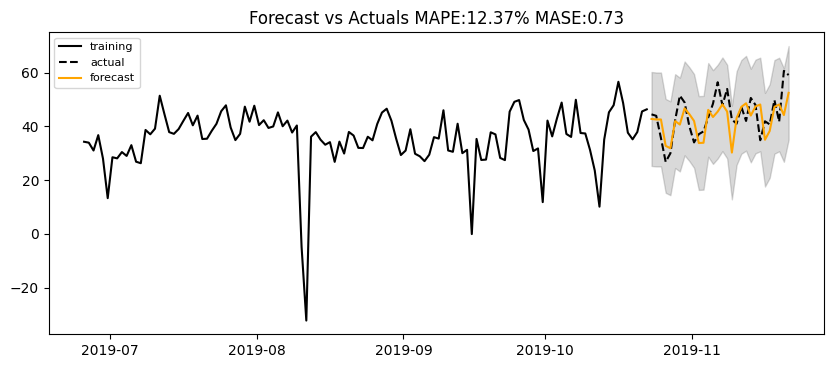

In [90]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-11-22 11:00:00', exog=('load', (1,1,1), (1,0,0,7)))

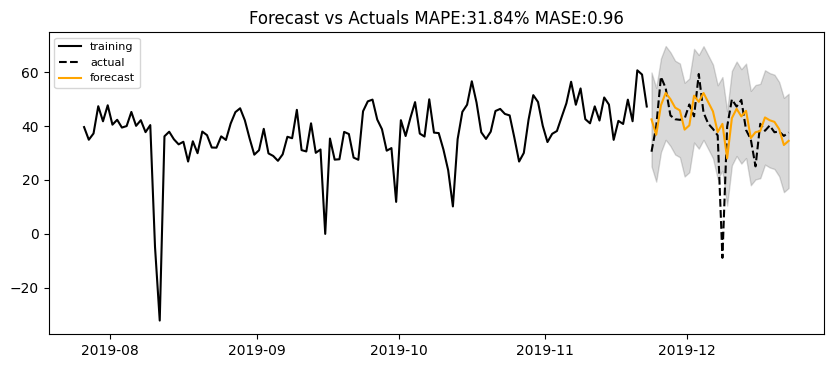

In [92]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

### Wind_speed as exogenous feature

In [94]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.wind_speed,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.68 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.70 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.39 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.41 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.81 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.88 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.98 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.22 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.92 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=('wind_speed', (1,1,1), (1,0,2,7)))

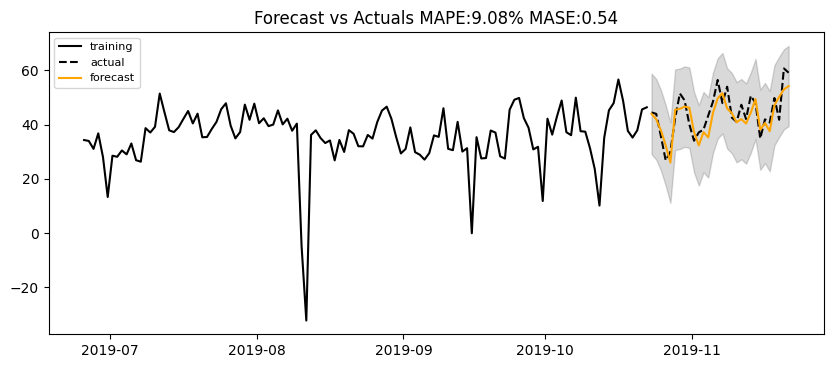

In [96]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-11-22 11:00:00', exog=('wind_speed', (1,1,1), (1,0,2,7)))

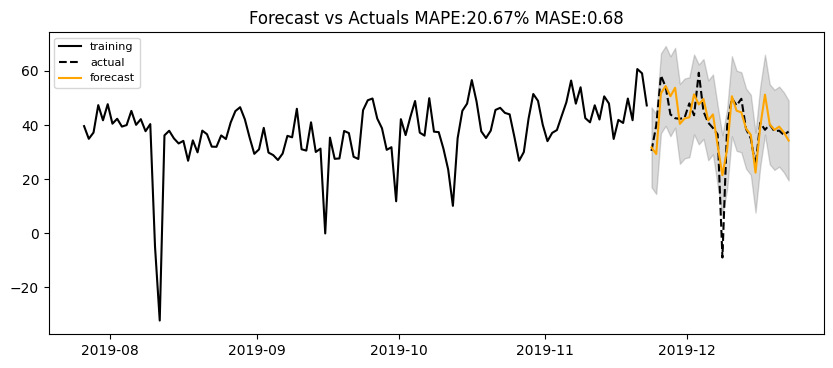

In [98]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

### Holiday as exogenous feature

In [101]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.holiday,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.88 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.81 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.59 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.42 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.78 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.87 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.66 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.87 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.25 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-12-22 11:00:00', exog=('holiday', (1,1,1), (1,0,2,7)))

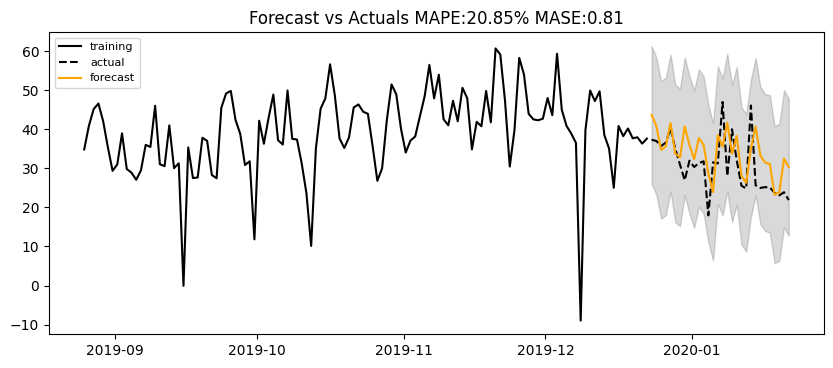

In [111]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

### Holiday and dayofweek as exogenous feature

In [12]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train[['holiday','weekend']],
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.87 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.73 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.49 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.38 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.83 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.87 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.97 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.25 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=16.35 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-12-22 11:00:00', exog=(['holiday', 'weekend'], (1,1,1), (1,0,2,7)))

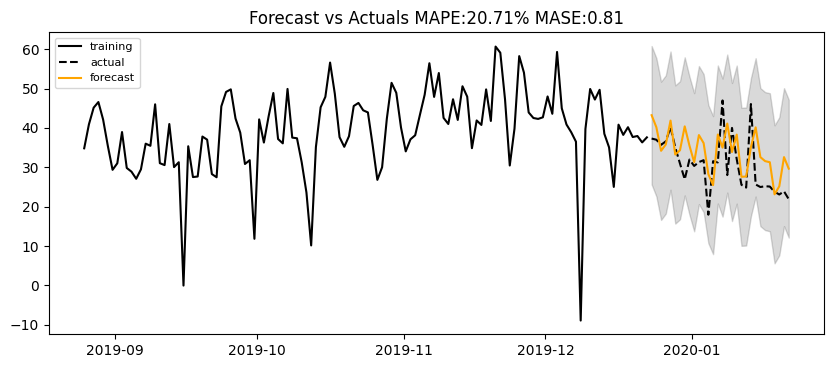

In [18]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

### Temperature as exogenous feature

In [19]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.temp,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.91 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.94 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.74 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.76 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.52 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.92 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.89 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.81 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.17 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.81 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=('temp', (1,1,1), (1,0,2,7)))

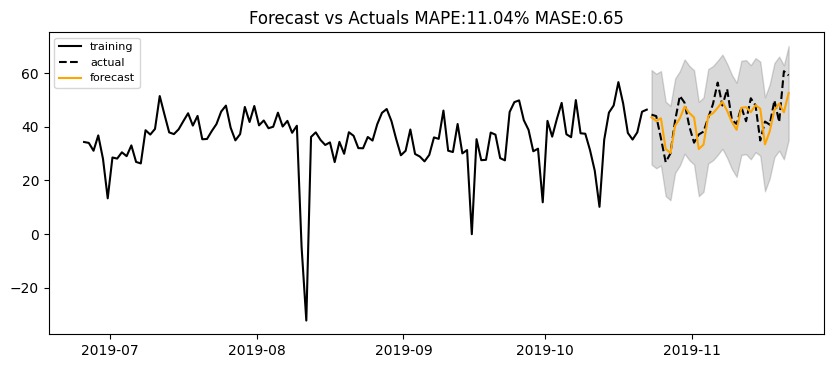

In [21]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-11-22 11:00:00', exog=('temp', (1,1,1), (1,0,2,7)))

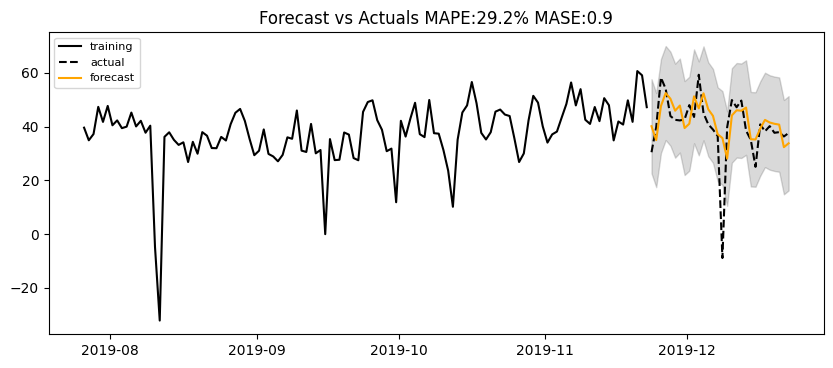

In [23]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

###  Clouds as exogenous feature

In [24]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.clouds_all,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.80 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.81 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.60 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.40 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=4.02 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.98 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.82 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.05 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.60 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=('clouds_all', (1,1,1), (1,0,2,7)))

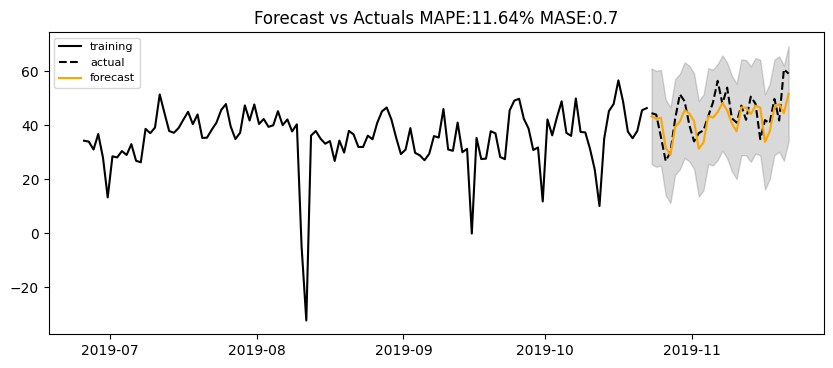

In [27]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-11-22 11:00:00', exog=('clouds_all', (1,1,1), (1,0,2,7)))

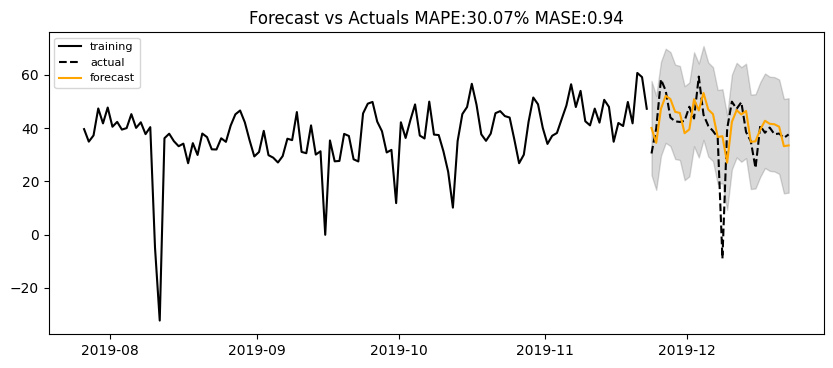

In [29]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

###  Humidity as exogenous feature

In [30]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.humidity,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.82 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.94 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.89 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.73 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.84 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.44 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=4.23 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.98 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=12.33 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.26 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.88 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=('humidity', (1,1,1), (1,0,2,7)))

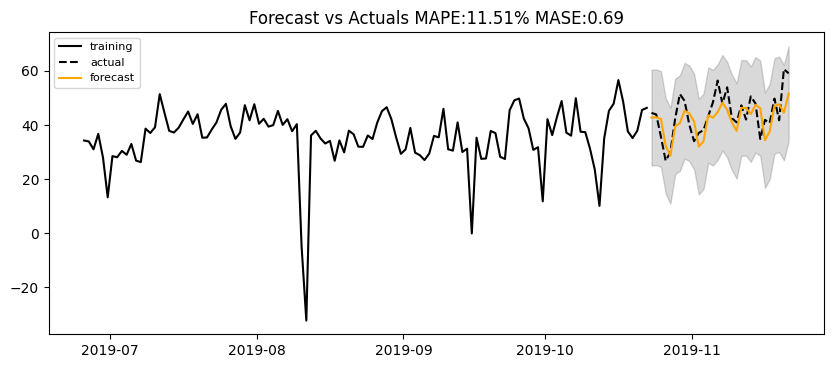

In [32]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df,split_date = '2019-11-22 11:00:00', exog=('humidity', (1,1,1), (1,0,2,7)))

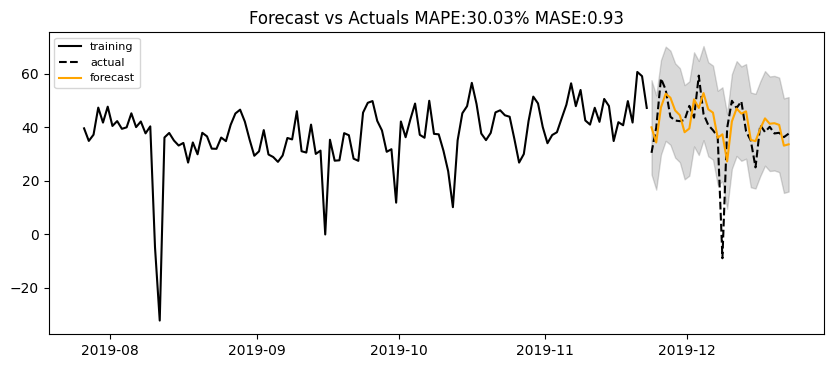

In [34]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

###  Coal_price as exogenous feature

In [35]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train.coal_price,
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.96 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.32 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.13 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.79 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.66 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.37 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.85 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.97 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=12.00 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.04 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.87 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
tmp = df.dropna()
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=tmp, exog=('coal_price', (1,1,1), (1,0,2,7)))

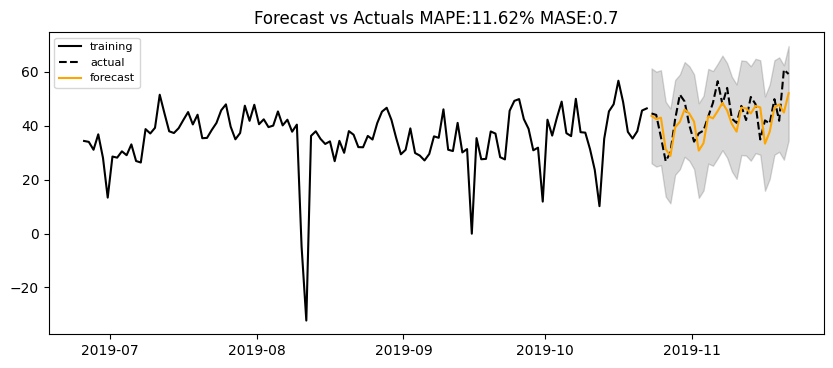

In [39]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=tmp,split_date = '2019-11-22 11:00:00', exog=('coal_price', (1,1,1), (1,0,2,7)))

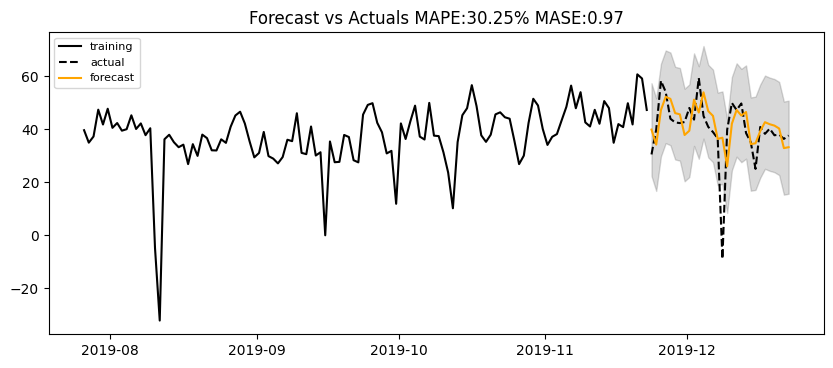

In [42]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

## Explore the impact of scaling exogenous features

- Features to include: **wind_speed, holidays, whether it is weekend, temp, humidity**
- Features to drop: load, total_prod, wind_prod, wind_share, clouds_all, coal_price

In [116]:
df = df[['price', 'wind_speed', 'holiday', 'weekend', 'temp', 'humidity']]

### Without scaling exogenous features

In [43]:
# Grid search hyper params
train = df[df.index < '2019-10-22 11:00:00']
model = pm.auto_arima(train.price, exog = train[['wind_speed', 'holiday', 'weekend', 'temp', 'humidity']],
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.81 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.74 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.69 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.53 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.38 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.79 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.89 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=11.72 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=5.93 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=15.40 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [102]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

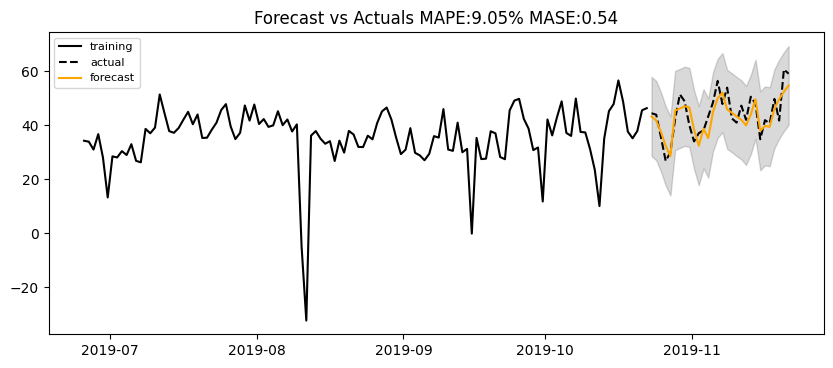

In [103]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [104]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, split_date = '2019-11-22 11:00:00', 
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

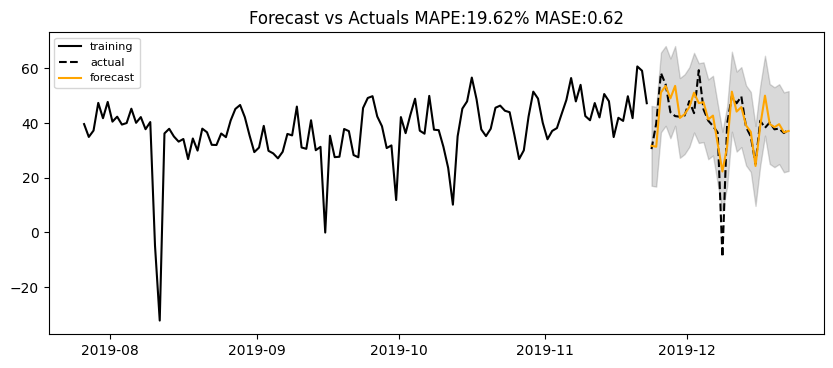

In [105]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, split_date = '2019-12-22 11:00:00', 
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

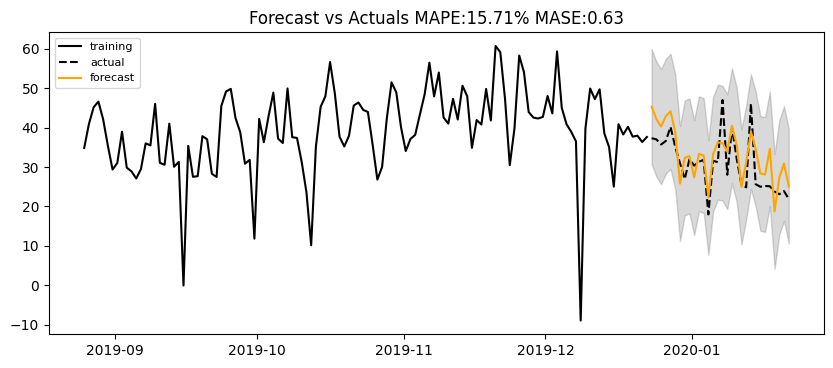

In [50]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [117]:
df.tail()

price  wind_speed  holiday  weekend      temp   humidity
2020-11-21 11:00:00   1.05    7.056021      0.0      1.0  9.070523  94.182973
2020-11-22 11:00:00   1.16    7.283847      0.0      1.0  8.228828  74.997025
2020-11-23 11:00:00   4.95    6.475636      0.0      0.0  7.591355  80.983497
2020-11-24 11:00:00    NaN    6.487594      NaN      NaN  9.836759  93.302050
2020-11-25 11:00:00    NaN         NaN      NaN      NaN       NaN        NaN

In [118]:
# 2020-10-22 + 30 days
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, split_date = '2020-10-22 11:00:00', 
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

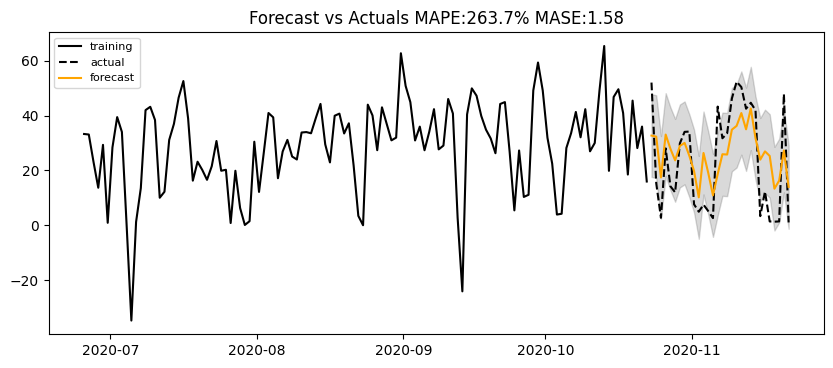

In [119]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

- Forecasting for 2020 is not very accurate due to Covid19 caused irregular electricity demand. Need further feature engineering for 2020 forecast.

### With scaling wind_speed, temp, humidity

In [70]:
df.head()

price  wind_speed  holiday  weekend      temp   humidity
2015-01-01 11:00:00  16.08    8.724397      1.0      0.0  6.732469  93.413145
2015-01-02 11:00:00  15.08   11.233930      0.0      0.0  6.849566  80.994869
2015-01-03 11:00:00  22.31    6.187115      0.0      1.0  4.332541  88.760764
2015-01-04 11:00:00  27.32    5.591671      0.0      1.0  3.296271  79.233305
2015-01-05 11:00:00  40.97    2.044551      0.0      0.0  4.498201  93.718424

In [110]:
from sklearn.preprocessing import StandardScaler
train = df[df.index < '2019-10-22 11:00:00']
scaler = StandardScaler()
scaler = scaler.fit(train[['wind_speed', 'temp', 'humidity']])
train.loc[:,['wind_speed', 'temp', 'humidity']]=\
scaler.transform(train[['wind_speed', 'temp', 'humidity']])
train.head()

c:\users\guli\.venvs\lewagon_project\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
c:\users\guli\.venvs\lewagon_project\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


price  wind_speed  holiday  weekend      temp  humidity
2015-01-01 11:00:00  16.08    2.030745      1.0      0.0 -0.560728  1.078172
2015-01-02 11:00:00  15.08    3.289867      0.0      0.0 -0.542896  0.164357
2015-01-03 11:00:00  22.31    0.757700      0.0      1.0 -0.926206  0.735821
2015-01-04 11:00:00  27.32    0.458945      0.0      1.0 -1.084016  0.034730
2015-01-05 11:00:00  40.97   -1.320772      0.0      0.0 -0.900978  1.100637

In [79]:
# Grid search hyper params
model = pm.auto_arima(train.price, exog = train.drop('price', axis=1),
                       seasonal=True, m=7, 
                       start_p=0, max_p=2, start_q=0, max_q=2,
                       start_P=0, max_P=2, start_Q=0, max_Q=2, 
                       trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=13510.004, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=13317.013, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=13086.081, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=13508.007, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=13096.267, Time=0.30 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=7.08 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=13068.790, Time=2.77 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=10.94 sec
 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=13476.329, Time=1.40 sec
 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=12900.292, Time=3.99 sec
 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=12916.945, Time=1.94 sec
 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=12792.791, Time=12.34 sec
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=6.73 sec
 ARIMA(1,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=16.39 sec
 ARIMA(1,1,1)(2,0,1)[7] intercept   : AI

In [ ]:
# with MinMaxScaling 2019-10-22 + 30 days
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

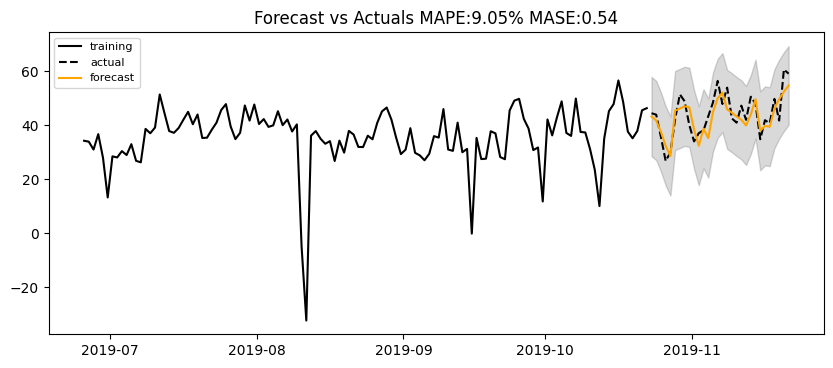

In [107]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [ ]:
# with MinMaxScaling 2019-11-22 + 30 days
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, split_date = '2019-11-22 11:00:00', exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

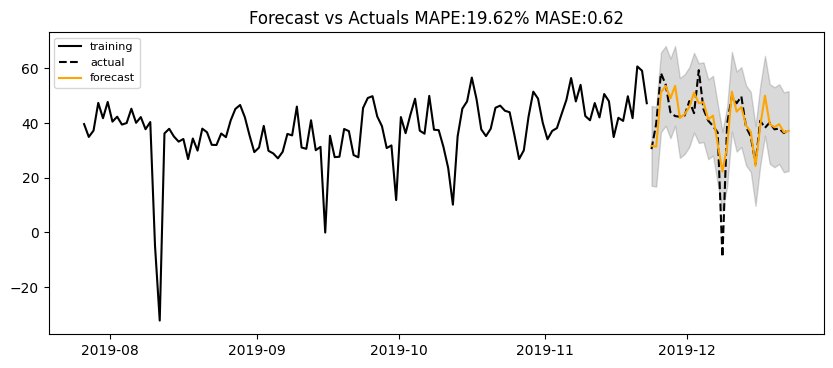

In [112]:
plot_forecast(forecast, train.iloc[-120:, 0], test.price, lower, upper, mape=mape, mase=mase)

## Walk forward validation for 6 months

- As shown above, scaling the exogenous features does not imperove the performance. So I will keep features without scaling.

In [121]:
# evaluate the sarima model on test_set(2019-6-30 till 2019-12-31, 184 days)
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, split_date = '2019-06-30 11:00:00', n=184,
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

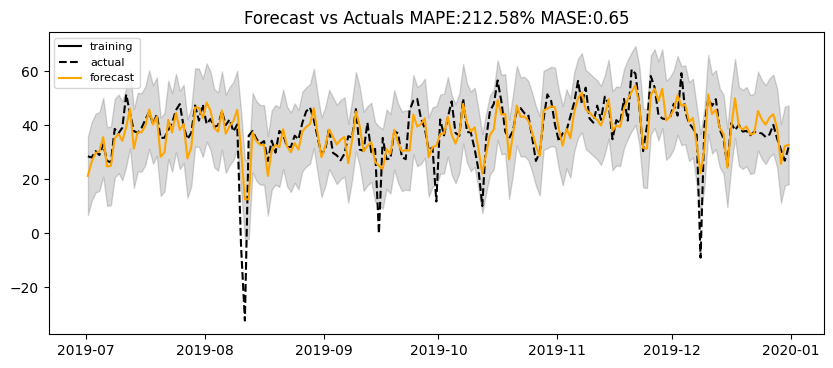

In [126]:
plot_forecast(forecast, train.iloc[-1:, 0], test.price, lower, upper, mape=mape, mase=mase)

In [129]:
test.price[75:85]

2019-09-14 11:00:00    31.28
2019-09-15 11:00:00    -0.07
2019-09-16 11:00:00    35.34
2019-09-17 11:00:00    27.51
2019-09-18 11:00:00    27.65
2019-09-19 11:00:00    37.81
2019-09-20 11:00:00    37.02
2019-09-21 11:00:00    28.27
2019-09-22 11:00:00    27.46
2019-09-23 11:00:00    45.48
Name: price, dtype: float64

In [131]:
# evaluate the sarima model on test_set(2019-9-30 till 2020-3-31, 183 days)
forecast, lower, upper, mape, mase, train, test = \
train_sarima(data=df, split_date = '2019-09-30 11:00:00', n=183,
             exog=(['wind_speed', 'holiday', 'weekend', 'temp', 'humidity'], (1,1,1), (1,0,2,7)))

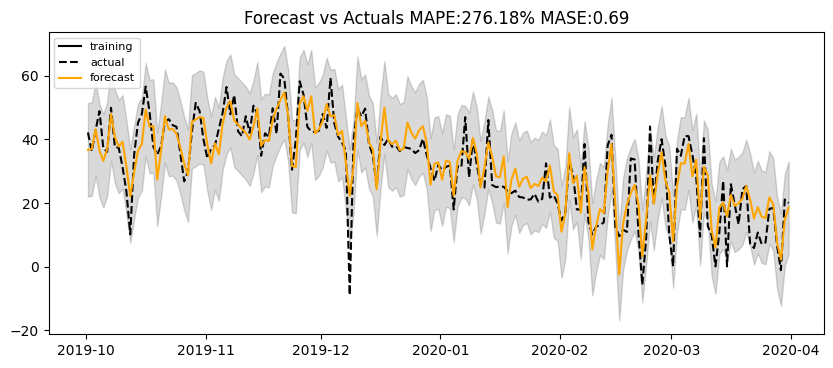

In [132]:
plot_forecast(forecast, train.iloc[-1:, 0], test.price, lower, upper, mape=mape, mase=mase)

# 24 hourly forecast

- consider moving to the GCP